# **Importing Libraries**

In [ ]:
!pip install -q --upgrade fastcore
!pip install -q --upgrade fastai
!pip install -q nbdev

     |████████████████████████████████| 40kB 2.9MB/s 
     |████████████████████████████████| 358kB 6.9MB/s 
     |████████████████████████████████| 61kB 3.4MB/s 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as PImage
from fastai.vision.all import *

from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)



In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CGIAR/Train.csv')
img_path = '/content/drive/My Drive/Colab Notebooks/CGIAR/Images'


In [ ]:
image_count = np.zeros((7,1))
for i in range(7):
  image_count[i] = np.sum(df['growth_stage'] == i+1)
#print(image_count)

In [ ]:
quality_count = np.zeros((2,1))
for i in range(2):
  quality_count[i] = np.sum(df['label_quality'] == i+1)
#print(quality_count)

In [ ]:
b = 0
for i in range(7):
  a = np.sum((df['growth_stage'] == i+1) & (df['label_quality'] == 2))
  #print(f'For {i+1}: {a}')
  b += a
#print(f'Sum: {b}')

In [ ]:
lis_im = []
for im_id in train.UID:
  im = PImage.open(f'{img_path}/{im_id}.jpeg')
  lis_im.append(np.asarray(im))


In [ ]:
tsne = TSNE()
X_embedded = tsne.fit_transform(np.array(lis_im[0]))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)

In [ ]:

# plt.figure()
# fig, axs = plt.subplots(4, 2, figsize=(12, 16))
# num = 7
# for i, ax in enumerate(axs.flatten()):
#   if num in df['growth_stage'].unique(): # If i+1 is a valid growth stage
#     im_id = df.loc[(df.growth_stage == num) & (df.label_quality==2)].sample()['UID'].values[0]
#     print(im_id) 
#     im = PImage.open(f'{img_path}/{im_id}.jpeg')
#     ax.imshow(im)
#     ax.set_title( f'Growth Stage {num}')


In [ ]:

train = df.loc[(df.label_quality==2)]
train_1 = df.loc[(df.label_quality==1) & (df.growth_stage==1)].sample(n=50, random_state=42)
train_6 = df.loc[(df.label_quality==1) & (df.growth_stage==6)].sample(n=50, random_state=42)

train = train.append([train_1, train_6], ignore_index=True).sample(frac=1)

In [ ]:

# n = 0.1
# lis = []
# for uid in (train['UID']):
#   img = img_path + '/' + uid + '.jpeg'
#   a = PImage.open(img)
#   b = np.asarray(a)
#   count = 0
#   for i in range(len(b)):
#     for j in range(len(b[0])):
#       if (b[i][j][0] == 0) & (b[i][j][1] == 0) & (b[i][j][2] == 0):
#         count += 1
#   if count > n*len(b)*len(b[0]):
#     lis.append(uid)

# df1 = pd.DataFrame(lis, columns=['UID'])
# df1.to_csv('/content/drive/My Drive/Colab Notebooks/CGIAR/list.csv', index=False)




In [ ]:
#files = get_image_files(img_path)
#print(len(files))

In [ ]:
df1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CGIAR/list.csv')

train = train.set_index('UID')
train = train.drop(list(df1.UID), axis=0)
train = train.reset_index()

In [ ]:
train

,UID,growth_stage,label_quality
0,gU4QuTrj,4,2
1,LRiFB5zl,7,2
2,hde3LUfQ,2,2
3,vAlFciQm,7,2
4,bAuckzmU,2,2
...,...,...,...
2722,DvMTqrdl,3,2
2723,GbBioQWO,5,2
2724,hEPBDtrb,4,2
2725,2SMaTcbN,3,2


In [ ]:
# doc(ImageDataLoaders.from_df)

In [ ]:
dls = ImageDataLoaders.from_df(train, path='/content/drive/My Drive/Colab Notebooks/CGIAR/Images', suff='.jpeg',
                               label_col='growth_stage', item_tfms=Resize(224), valid_pct=0.2, seed=42,
                               y_block=RegressionBlock,bs=64)

fastai.data.core.DataLoaders

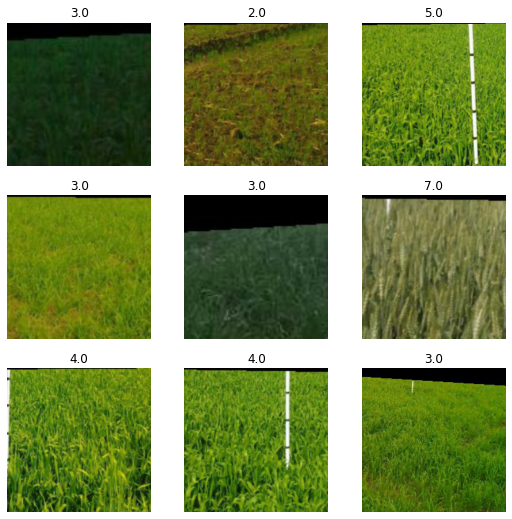

In [ ]:
dls.show_batch()
type(dls)

In [ ]:
# doc(cnn_learner)

In [ ]:
learn = cnn_learner(dls, resnet152, metrics=rmse) 
learn.fine_tune(30) 

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


RuntimeError: ignored

In [ ]:
ss = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CGIAR/SampleSubmission.csv')
tdl = learn.dls.test_dl(ss) # Make test dataloader
preds = learn.tta(dl=tdl) # Test Time Augmentation

In [ ]:
ss['growth_stage'] = preds[0].numpy() # This time our outputs are in the format we want, so this part is much easier
ss.to_csv('/content/drive/My Drive/Colab Notebooks/CGIAR/sub.csv', index=False)

In [ ]:
learn.export('/content/drive/My Drive/Colab Notebooks/CGIAR/model_resnet152_h.pkl')